In [64]:
!nvidia-smi

Tue Jul  7 14:59:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    76W / 149W |    147MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.model_selection import learning_curve, GridSearchCV

In [66]:
pharma_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/pharma_data/Training_set_advc.csv')
pharma_data.head()

,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Treated_with_drugs,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,Patient_mental_condition,A,B,C,D,E,F,Z,Number_of_prev_cond,Survived_1_year
0,16201,47,8433,DX2,60,21.655523,NO,URBAN,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1
1,9421,3,2972,DX6,2,28.852743,NO,RURAL,Stable,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0
2,16205,7,8608,Dx6,20,26.179725,NO,RURAL,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1
3,5582,31,10074,dx6,8,22.638945,NO,RURAL,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0
4,20880,43,7462,dx1,53,21.326131,NO,RURAL,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [67]:
test_new = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/pharma_data/Testing_set_advc.csv')
test_new.head()

,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Treated_with_drugs,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,Patient_mental_condition,A,B,C,D,E,F,Z,Number_of_prev_cond
0,24206,35,4640,DX5,65,20.710365,NO,RURAL,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
1,32827,30,3214,dx1,2,24.250219,NO,URBAN,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
2,3694,46,3564,dx6,1,27.139276,NO,URBAN,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,7164,44,5176,DX1,29,29.191759,NO,RURAL,Stable,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0
4,1259,30,1101,DX5,51,20.844146,NO,URBAN,Stable,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [68]:
clm_lst = ['A', 'B', 'C', 
           'D', 'E', 'F', 
           'Z', 'Number_of_prev_cond']

pharma_data.loc[pharma_data['Number_of_prev_cond'].isna(), clm_lst] = 0
pharma_data = pharma_data[pharma_data['Treated_with_drugs'].notna()]
pharma_data.reset_index(drop=True, inplace=True)
pharma_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25071 entries, 0 to 25070
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID_Patient_Care_Situation  25071 non-null  int64  
 1   Diagnosed_Condition        25071 non-null  int64  
 2   Patient_ID                 25071 non-null  int64  
 3   Treated_with_drugs         25071 non-null  object 
 4   Patient_Age                25071 non-null  int64  
 5   Patient_Body_Mass_Index    25071 non-null  float64
 6   Patient_Smoker             25071 non-null  object 
 7   Patient_Rural_Urban        25071 non-null  object 
 8   Patient_mental_condition   25071 non-null  object 
 9   A                          25071 non-null  float64
 10  B                          25071 non-null  float64
 11  C                          25071 non-null  float64
 12  D                          25071 non-null  float64
 13  E                          25071 non-null  flo

In [69]:
pharma_data['Treated_with_drugs'] = pharma_data['Treated_with_drugs'].str.lower().str.strip().str.split()

test_new['Treated_with_drugs'] = test_new['Treated_with_drugs'].str.lower().str.strip().str.split()

In [70]:
drug_list = ['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6']
def encodeDrug(x):
    return [1 if drug in x else 0 for drug in drug_list]
    
pharma_data['Treated_with_drugs_encoded'] = pharma_data.Treated_with_drugs.apply(lambda x: encodeDrug(x))

test_new['Treated_with_drugs_encoded'] = test_new.Treated_with_drugs.apply(lambda x: encodeDrug(x))

In [71]:
pharma_data[drug_list] = pd.DataFrame(pharma_data['Treated_with_drugs_encoded'].to_list(), columns=drug_list)
pharma_data['Treated_drugs_Total'] = pharma_data.iloc[:,-6:].sum(axis=1)


test_new[drug_list] = pd.DataFrame(test_new['Treated_with_drugs_encoded'].to_list(), columns=drug_list)
test_new['Treated_drugs_Total'] = test_new.iloc[:,-6:].sum(axis=1)

In [72]:
pharma_data['Patient_Smoker'] = pharma_data['Patient_Smoker'].str.lower().str.strip()
pharma_data.loc[pharma_data['Patient_Smoker'] == 'yess', 'Patient_Smoker'] = 'yes'

test_new['Patient_Smoker'] = test_new['Patient_Smoker'].str.lower().str.strip()
test_new.loc[test_new['Patient_Smoker'] == 'yess', 'Patient_Smoker'] = 'yes'

In [73]:
def encodeAge(x):
  if x <= 15:
    return 'A1'
  elif x <= 30:
    return 'A2'
  elif x <= 45:
    return 'A3'
  elif x <= 60:
    return 'A4'
  else:
    return 'A5'

pharma_data['Patient_Age_encoded'] = pharma_data.Patient_Age.apply(lambda x: encodeAge(x))

test_new['Patient_Age_encoded'] = test_new.Patient_Age.apply(lambda x: encodeAge(x))

In [74]:
pharma_data = pd.get_dummies(pharma_data, columns=['Patient_Rural_Urban', 'Patient_Smoker', 'Patient_Age_encoded'])

test_new = pd.get_dummies(test_new, columns=['Patient_Rural_Urban', 'Patient_Smoker', 'Patient_Age_encoded'])

In [75]:
drop_columns = ['ID_Patient_Care_Situation',
                'Patient_ID', 
                'Patient_mental_condition',
                'Treated_with_drugs', 
                'Treated_with_drugs_encoded']

pharma_data.drop(drop_columns, axis=1, inplace=True)

test_new.drop(drop_columns, axis=1, inplace=True)

In [76]:
toInt = ['A', 'B', 'C', 'D', 'E', 'F', 'Z', 'Number_of_prev_cond']

pharma_data[toInt] = pharma_data[toInt].astype(int)

test_new[toInt] = test_new[toInt].astype(int)

**XGBoost SKLearn**

In [77]:
def printEval(y_true, y_pred):
    print('F1 Score', f1_score(y_true, y_pred))
    print('ROC AUC', roc_auc_score(y_true, y_pred))
    print('Precision', precision_score(y_true, y_pred))
    print('Recall Score', recall_score(y_true, y_pred))
    print('Accuracy', accuracy_score(y_true, y_pred))

In [31]:
y = pharma_data['Survived_1_year']
x = pharma_data.drop(['Survived_1_year'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)


xgbClf = xgb.XGBClassifier(max_depth=7, min_child_weight=6, random_state=47)
xgbClf.fit(x_train, y_train, eval_metric=f1_score)

y_pred_train = xgbClf.predict(x_train)
y_pred = xgbClf.predict(x_test)

print('For TrainData \n')
printEval(np.array(y_pred_train).astype(int), y_train)

print('\n For TestData \n')
printEval(y_pred, y_test)

x_train (20056, 27)
x_test (5015, 27)
y_train (20056,)
y_test (5015,)
For TrainData 

F1 Score 0.9119058677813904
ROC AUC 0.8813184576301656
Precision 0.9260278280009433
Recall Score 0.8982081585970263
Accuracy 0.8865177502991624

 For TestData 

F1 Score 0.8875921375921376
ROC AUC 0.8476337229442327
Precision 0.9090909090909091
Recall Score 0.8670867086708671
Accuracy 0.8540378863409771


In [32]:
xgbClf = xgb.XGBClassifier(max_depth=7, min_child_weight=6, random_state=47)
xgbClf.fit(x, y, eval_metric=f1_score)

test_pred = xgbClf.predict(test_new)
values = list(test_pred)

with open("predictionXGB.txt", "w") as output:
    output.write(str(values))

**H2O AutoML**

In [33]:
pharma_data.loc[pharma_data['Survived_1_year'] == 1, 'Survived_1_year'] = 'yes'
pharma_data.loc[pharma_data['Survived_1_year'] == 0, 'Survived_1_year'] = 'no'
pharma_data.to_csv('pharma_data.csv', index=False)

In [34]:
!pip install h2o

     |████████████████████████████████| 128.4MB 93kB/s 
  Created wheel for h2o: filename=h2o-3.30.0.6-py2.py3-none-any.whl size=128412300 sha256=538d0e7516689cdb2a7d1dd870d3538355b571c6584ff83ff9d4d3e2c9e08172
  Stored in directory: /root/.cache/pip/wheels/de/4c/dd/4813e95c4b5328b4de2e2e1aa56ca66a547f45d11fe47c3c8a
Successfully built h2o


In [35]:
import h2o

In [36]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.7" 2020-04-14; OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2qv2i9uk
  JVM stdout: /tmp/tmp2qv2i9uk/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp2qv2i9uk/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,6 days
H2O_cluster_name:,H2O_from_python_unknownUser_fwng1a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [37]:
from h2o.automl import H2OAutoML

In [38]:
churn_df = h2o.upload_file('/content/pharma_data.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [39]:
churn_df.types

{'A': 'int',
 'B': 'int',
 'C': 'int',
 'D': 'int',
 'Diagnosed_Condition': 'int',
 'E': 'int',
 'F': 'int',
 'Number_of_prev_cond': 'int',
 'Patient_Age': 'int',
 'Patient_Age_encoded_A1': 'int',
 'Patient_Age_encoded_A2': 'int',
 'Patient_Age_encoded_A3': 'int',
 'Patient_Age_encoded_A4': 'int',
 'Patient_Age_encoded_A5': 'int',
 'Patient_Body_Mass_Index': 'real',
 'Patient_Rural_Urban_RURAL': 'int',
 'Patient_Rural_Urban_URBAN': 'int',
 'Patient_Smoker_no': 'int',
 'Patient_Smoker_yes': 'int',
 'Survived_1_year': 'enum',
 'Treated_drugs_Total': 'int',
 'Z': 'int',
 'dx1': 'int',
 'dx2': 'int',
 'dx3': 'int',
 'dx4': 'int',
 'dx5': 'int',
 'dx6': 'int'}

In [40]:
churn_train,churn_test = churn_df.split_frame(ratios=[.8])

In [41]:
y = "Survived_1_year"
x = churn_df.columns
x.remove(y)

In [42]:
aml = H2OAutoML(max_models = 30, 
                exclude_algos = ["GBM", "DeepLearning"], 
                verbosity="info", nfolds=3)    #sort_metric = "AUC",
                
aml.train(x = x, y = y, training_frame = churn_df)

AutoML progress: |
14:31:39.549: Project: AutoML_20200707_143139540
14:31:39.551: Setting stopping tolerance adaptively based on the training frame: 0.006315593535871559
14:31:39.552: Build control seed: -1 (random)
14:31:39.553: training frame: Frame key: automl_training_Key_Frame__upload_a2921979eaa51f6396add1eeae6d43c9.hex    cols: 28    rows: 25071  chunks: 1    size: 374102  checksum: 6025084801457614733
14:31:39.553: validation frame: NULL
14:31:39.553: leaderboard frame: NULL
14:31:39.553: blending frame: NULL
14:31:39.554: response column: Survived_1_year
14:31:39.554: fold column: null
14:31:39.554: weights column: null
14:31:39.620: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
14:31:39.640: Disabling Algo: GBM as requested by the user.
14:31:39.

In [43]:
lb = aml.leaderboard
lb.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20200707_143139,0.931047,0.334608,0.961677,0.173184,0.325076,0.105674
StackedEnsemble_BestOfFamily_AutoML_20200707_143139,0.929955,0.336125,0.961055,0.177859,0.325709,0.106087
XGBoost_grid__1_AutoML_20200707_143139_model_1,0.927944,0.32491,0.959948,0.184531,0.324815,0.105505
XGBoost_3_AutoML_20200707_143139,0.927,0.327203,0.959294,0.184906,0.32597,0.106256
XGBoost_grid__1_AutoML_20200707_143139_model_19,0.926964,0.32752,0.959307,0.191324,0.325839,0.106171
XGBoost_grid__1_AutoML_20200707_143139_model_7,0.926923,0.327437,0.95922,0.182538,0.325999,0.106275
XGBoost_grid__1_AutoML_20200707_143139_model_14,0.926891,0.328463,0.959208,0.18408,0.325929,0.106229
XGBoost_grid__1_AutoML_20200707_143139_model_20,0.926672,0.328475,0.959072,0.18571,0.326227,0.106424
XGBoost_grid__1_AutoML_20200707_143139_model_9,0.92633,0.328711,0.958823,0.189587,0.326677,0.106718
XGBoost_grid__1_AutoML_20200707_143139_model_4,0.925815,0.329924,0.958558,0.183006,0.327092,0.106989


In [44]:
churn_pred=aml.leader.predict(churn_test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [45]:
churn_pred.head()

predict,no,yes
yes,0.296522,0.703478
yes,0.159797,0.840203
yes,0.0364752,0.963525
yes,0.036076,0.963924
no,0.955493,0.0445068
yes,0.0352776,0.964722
yes,0.300217,0.699783
yes,0.0784131,0.921587
yes,0.0359282,0.964072
yes,0.0429437,0.957056


In [46]:
aml.leader.model_performance(churn_test)


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.048040416415912654
RMSE: 0.21918124102192837
LogLoss: 0.18045580793245714
Null degrees of freedom: 4947
Residual degrees of freedom: 4935
Null deviance: 6509.55897544844
Residual deviance: 1785.7906752995957
AIC: 1811.7906752995957
AUC: 0.9872794644613698
AUCPR: 0.9928947658989635
Gini: 0.9745589289227397

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5353424677841897: 


,,no,yes,Error,Rate
0,no,1659.0,161.0,0.0885,(161.0/1820.0)
1,yes,141.0,2987.0,0.0451,(141.0/3128.0)
2,Total,1800.0,3148.0,0.061,(302.0/4948.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.535342,0.951880,200.0
1,max f2,0.331829,0.964714,262.0
2,max f0point5,0.743721,0.964632,133.0
3,max accuracy,0.537546,0.938965,199.0
4,max precision,0.965106,1.000000,0.0
5,max recall,0.131999,1.000000,333.0
6,max specificity,0.965106,1.000000,0.0
7,max absolute_mcc,0.537546,0.868564,199.0
8,max min_per_class_accuracy,0.611483,0.936264,176.0
9,max mean_per_class_accuracy,0.622996,0.936922,173.0



Gains/Lift Table: Avg response rate: 63.22 %, avg score: 62.87 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010105,0.965201,1.581841,1.581841,1.000000,0.965249,1.000000,0.965249,0.015985,0.015985,58.184143,58.184143,0.015985
1,2,0.020210,0.965154,1.581841,1.581841,1.000000,0.965174,1.000000,0.965211,0.015985,0.031969,58.184143,58.184143,0.031969
2,3,0.030113,0.965037,1.581841,1.581841,1.000000,0.965103,1.000000,0.965175,0.015665,0.047634,58.184143,58.184143,0.047634
3,4,0.040016,0.964938,1.581841,1.581841,1.000000,0.964991,1.000000,0.965130,0.015665,0.063299,58.184143,58.184143,0.063299
4,5,0.050121,0.964840,1.581841,1.581841,1.000000,0.964890,1.000000,0.965081,0.015985,0.079284,58.184143,58.184143,0.079284
5,6,0.100040,0.964196,1.581841,1.581841,1.000000,0.964570,1.000000,0.964826,0.078964,0.158248,58.184143,58.184143,0.158248
6,7,0.150162,0.963129,1.581841,1.581841,1.000000,0.963692,1.000000,0.964448,0.079284,0.237532,58.184143,58.184143,0.237532
7,8,0.200081,0.961659,1.581841,1.581841,1.000000,0.962456,1.000000,0.963951,0.078964,0.316496,58.184143,58.184143,0.316496
8,9,0.300121,0.956543,1.581841,1.581841,1.000000,0.959373,1.000000,0.962425,0.158248,0.474744,58.184143,58.184143,0.474744
9,10,0.399960,0.934131,1.581841,1.581841,1.000000,0.948983,1.000000,0.959069,0.157928,0.632673,58.184143,58.184143,0.632673


In [47]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

['StackedEnsemble_AllModels_AutoML_20200707_143139',
 'StackedEnsemble_BestOfFamily_AutoML_20200707_143139',
 'XGBoost_grid__1_AutoML_20200707_143139_model_1',
 'XGBoost_3_AutoML_20200707_143139',
 'XGBoost_grid__1_AutoML_20200707_143139_model_19',
 'XGBoost_grid__1_AutoML_20200707_143139_model_7',
 'XGBoost_grid__1_AutoML_20200707_143139_model_14',
 'XGBoost_grid__1_AutoML_20200707_143139_model_20',
 'XGBoost_grid__1_AutoML_20200707_143139_model_9',
 'XGBoost_grid__1_AutoML_20200707_143139_model_4',
 'XGBoost_grid__1_AutoML_20200707_143139_model_15',
 'XGBoost_grid__1_AutoML_20200707_143139_model_3',
 'XGBoost_grid__1_AutoML_20200707_143139_model_8',
 'XGBoost_grid__1_AutoML_20200707_143139_model_5',
 'XGBoost_grid__1_AutoML_20200707_143139_model_10',
 'XGBoost_grid__1_AutoML_20200707_143139_model_12',
 'XGBoost_grid__1_AutoML_20200707_143139_model_2',
 'XGBoost_grid__1_AutoML_20200707_143139_model_13',
 'XGBoost_grid__1_AutoML_20200707_143139_model_6',
 'XGBoost_grid__1_AutoML_202007

In [48]:
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])
out.params

{'backend': {'actual': 'auto', 'default': 'auto'},
 'booster': {'actual': 'dart', 'default': 'gbtree'},
 'build_tree_one_node': {'actual': False, 'default': False},
 'calibrate_model': {'actual': False, 'default': False},
 'calibration_frame': {'actual': None, 'default': None},
 'categorical_encoding': {'actual': 'AUTO', 'default': 'AUTO'},
 'checkpoint': {'actual': None, 'default': None},
 'col_sample_rate': {'actual': 1.0, 'default': 1.0},
 'col_sample_rate_per_tree': {'actual': 1.0, 'default': 1.0},
 'colsample_bylevel': {'actual': 1.0, 'default': 1.0},
 'colsample_bytree': {'actual': 1.0, 'default': 1.0},
 'distribution': {'actual': 'bernoulli', 'default': 'AUTO'},
 'dmatrix_type': {'actual': 'auto', 'default': 'auto'},
 'eta': {'actual': 0.3, 'default': 0.3},
 'export_checkpoints_dir': {'actual': None, 'default': None},
 'fold_assignment': {'actual': 'Modulo', 'default': 'AUTO'},
 'fold_column': {'actual': None, 'default': None},
 'gainslift_bins': {'actual': -1, 'default': -1},
 

In [49]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.01,
  'booster': 'dart',
  'colsample_bylevel': 1.0,
  'colsample_bytree': 1.0,
  'eta': 0.3,
  'gamma': 0.0,
  'gpu_id': 0,
  'grow_policy': 'depthwise',
  'lambda': 0.001,
  'max_bin': 256,
  'max_delta_step': 0.0,
  'max_depth': 5,
  'min_child_weight': 5.0,
  'normalize_type': 'tree',
  'nround': 70,
  'nthread': 2,
  'objective': 'binary:logistic',
  'one_drop': '0',
  'rate_drop': 0.0,
  'sample_type': 'uniform',
  'seed': -303195670,
  'silent': True,
  'skip_drop': 0.0,
  'subsample': 1.0,
  'updater': 'grow_gpu_hist'},
 70)

In [50]:
test_new.to_csv('test_new.csv', index=False)

In [51]:
test_churn_new = h2o.upload_file('/content/test_new.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [52]:
test_churn_pred = aml.leader.predict(test_churn_new)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [53]:
fnl_lst = list(test_churn_pred['predict'].as_data_frame().iloc[:,0])
values = [1 if pred=='yes' else 0 for pred in fnl_lst]

with open("predictionH2O.txt", "w") as output:
    output.write(str(values))

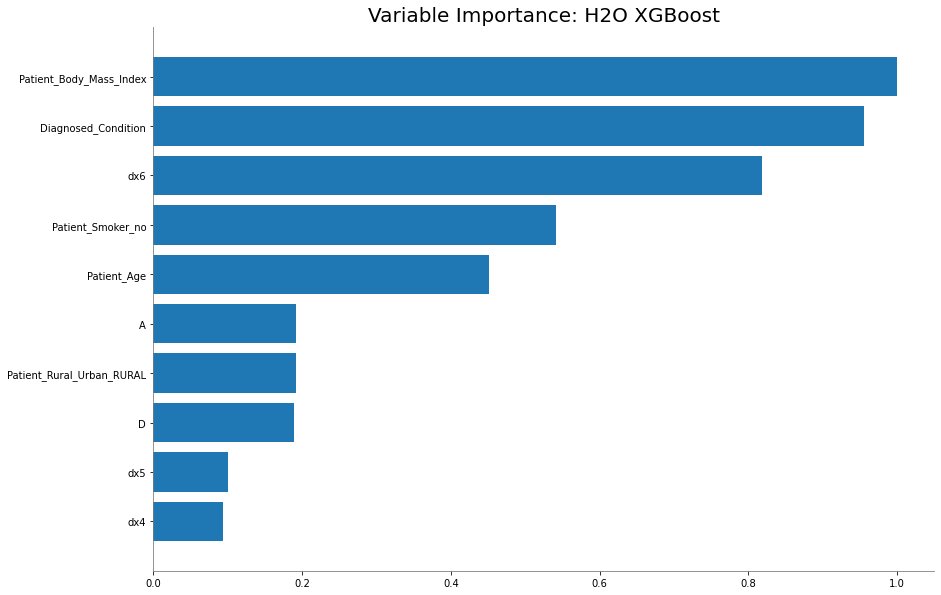

In [54]:
out.varimp_plot()

In [55]:
perf = aml.leader.model_performance(churn_test)
perf.F1()

[[0.5353424677841897, 0.9518801784576163]]

In [84]:
params = {'alpha': 0.01,
  'booster': 'dart',
  'colsample_bylevel': 1.0,
  'colsample_bytree': 1.0,
  'eta': 0.01,
  'gamma': 0.0,
  'gpu_id': 0,
  'grow_policy': 'depthwise',
  'lambda': 0.001,
  'max_bin': 256,
  'max_delta_step': 0.0,
  'max_depth': 7,
  'min_child_weight': 5.0,
  'normalize_type': 'tree',
  'nround': 70,
  'nthread': 2,
  'objective': 'binary:logistic',
  'one_drop': '0',
  'rate_drop': 0.0,
  'sample_type': 'uniform',
  'silent': True,
  'skip_drop': 0.0,
  'subsample': 1.0,
  'updater': 'grow_gpu_hist'}

In [79]:
pharma_data.loc[pharma_data['Survived_1_year'] == 'yes', 'Survived_1_year'] = 1
pharma_data.loc[pharma_data['Survived_1_year'] == 'no', 'Survived_1_year'] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [85]:
y = pharma_data['Survived_1_year']
x = pharma_data.drop(['Survived_1_year'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)


import xgboost as xgb
xgbClf = xgb.XGBClassifier(params=params)
xgbClf.fit(x_train, y_train, eval_metric=f1_score)

y_pred_train = xgbClf.predict(x_train)
y_pred = xgbClf.predict(x_test)

print('For TrainData \n')
printEval(np.array(y_pred_train).astype(int), y_train)

print('\n For TestData \n')
printEval(np.array(y_pred).astype(int), y_test)

x_train (20056, 27)
x_test (5015, 27)
y_train (20056,)
y_test (5015,)
For TrainData 

F1 Score 0.8755848008824313
ROC AUC 0.8307423551116615
Precision 0.9048030815187486
Recall Score 0.8481945467943994
Accuracy 0.836906661348225

 For TestData 

F1 Score 0.8769859282796187
ROC AUC 0.8338054464688083
Precision 0.9116074237181504
Recall Score 0.8448979591836735
Accuracy 0.8378863409770688
